In [3]:
import pandas as pd
import numpy as np
import warnings
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
# from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import plotly.express as px
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('datathon4.csv')

In [5]:
data.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [6]:
data.dtypes

encounter_id                     int64
patient_id                       int64
hospital_id                      int64
hospital_death                   int64
age                            float64
                                ...   
leukemia                       float64
lymphoma                       float64
solid_tumor_with_metastasis    float64
apache_3j_bodysystem            object
apache_2_bodysystem             object
Length: 186, dtype: object

In [7]:
### From the datathon dataset, select only the feature variables that will be used
### These feature variables are data available about the patient within the first hour of admittance into the ICU


data4 = data[['hospital_death','age', 'bmi','elective_surgery', 'ethnicity', 'gender', 'hospital_admit_source',
       'pre_icu_los_days', 'readmission_status', 'weight', 'icu_type',
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']]

In [8]:
# We will now reassign data into categorical form 
# Note this may not be necessary

data4["hospital_admit_source"] = data4["hospital_admit_source"].astype("category")
data4["ethnicity"] = data4["ethnicity"].astype("category")
data4["gender"] = data4["gender"].astype("category")
data4["icu_type"] = data4["icu_type"].astype("category")

# Categorization of Hospital Admit Source
data4['HAS_Floor'] = np.where(data4['hospital_admit_source']== 'Floor', 1, 0)
data4['HAS_Floor'] = data4['HAS_Floor'].astype('category')

data4['HAS_ED'] = np.where(data4['hospital_admit_source']== 'Emergency Department', 1, 0)
data4['HAS_ED'] = data4['HAS_ED'].astype('category')

data4['HAS_OR'] = np.where(data4['hospital_admit_source']== 'Operating Room', 1, 0)
data4['HAS_OR'] = data4['HAS_OR'].astype('category')

data4['HAS_Blank'] = np.where(data4['hospital_admit_source']== '', 1, 0)
data4['HAS_Blank'] = data4['HAS_Blank'].astype('category')

data4['HAS_DA'] = np.where(data4['hospital_admit_source']== 'Direct Admit', 1, 0)
data4['HAS_DA'] = data4['HAS_DA'].astype('category')

data4['HAS_OH'] = np.where(data4['hospital_admit_source']== 'Other Hospital', 1, 0)
data4['HAS_OH'] = data4['HAS_OH'].astype('category') 

data4['HAS_OICU'] = np.where(data4['hospital_admit_source']== 'Other ICU', 1, 0)
data4['HAS_OICU'] = data4['HAS_OICU'].astype('category')

data4['HAS_ICUtoSDU'] = np.where(data4['hospital_admit_source']== 'ICU to SDU', 1, 0)
data4['HAS_ICUtoSDU'] = data4['HAS_ICUtoSDU'].astype('category')

data4['HAS_RR'] = np.where(data4['hospital_admit_source']== 'Recovery Room', 1, 0)
data4['HAS_RR'] = data4['HAS_RR'].astype('category')

data4['HAS_CPC'] = np.where(data4['hospital_admit_source']== 'Chest Pain Center', 1, 0)
data4['HAS_CPC'] = data4['HAS_CPC'].astype('category')


data4['HAS_SDU'] = np.where(data4['hospital_admit_source']== 'Step-Down Unit (SDU)', 1, 0)
data4['HAS_SDU'] = data4['HAS_SDU'].astype('category')

data4['HAS_ACF'] = np.where(data4['hospital_admit_source']== 'Acute Care/Floor', 1, 0)
data4['HAS_ACF'] = data4['HAS_ACF'].astype('category')

data4['HAS_PACU'] = np.where(data4['hospital_admit_source']== 'PACU', 1, 0)
data4['HAS_PACU'] = data4['HAS_PACU'].astype('category')

data4['HAS_Obs'] = np.where(data4['hospital_admit_source']== 'Observation', 1, 0)
data4['HAS_Obs'] = data4['HAS_Obs'].astype('category')

data4['HAS_ICU'] = np.where(data4['hospital_admit_source']== 'ICU', 1, 0)
data4['HAS_ICU'] = data4['HAS_ICU'].astype('category')


# Categorization of Ethnicity 
data4['Ethnicity_Cau'] = np.where(data4['ethnicity']== 'Caucasian', 1, 0)
data4['Ethnicity_Cau'] = data4['Ethnicity_Cau'].astype('category')

data4['Ethnicity_Blank'] = np.where(data4['ethnicity']== '', 1, 0)
data4['Ethnicity_Blank'] = data4['Ethnicity_Blank'].astype('category')

data4['Ethnicity_Hisp'] = np.where(data4['ethnicity']== 'Hispanic', 1, 0)
data4['Ethnicity_Hisp'] = data4['Ethnicity_Hisp'].astype('category')

data4['Ethnicity_AA'] = np.where(data4['ethnicity']== 'African American', 1, 0)
data4['Ethnicity_AA'] = data4['Ethnicity_AA'].astype('category')

data4['Ethnicity_Asian'] = np.where(data4['ethnicity']== 'Asian', 1, 0)
data4['Ethnicity_Asian'] = data4['Ethnicity_Asian'].astype('category')

data4['Ethnicity_NA'] = np.where(data4['ethnicity']== 'Native American', 1, 0)
data4['Ethnicity_NA'] = data4['Ethnicity_NA'].astype('category')

data4['Ethnicity_Other_Unknown'] = np.where(data4['ethnicity']== 'Other/Unknown', 1, 0)
data4['Ethnicity_Other_Unknown'] = data4['Ethnicity_Other_Unknown'].astype('category')


# Categorization of Gender
data4['Gender'] = np.where(data4['gender']== 'M', 1, 0)
data4['Gender'] = data4['Gender'].astype('category')


# Categorization of Gender
data4['ICU_type_CT'] = np.where(data4['icu_type']== 'CTICU', 1, 0)
data4['ICU_type_CT'] = data4['ICU_type_CT'].astype('category')

data4['ICU_type_MS'] = np.where(data4['icu_type']== 'Med-Surg ICU', 1, 0)
data4['ICU_type_MS'] = data4['ICU_type_MS'].astype('category')

data4['ICU_type_CCU-CTI'] = np.where(data4['icu_type']== 'CCU-CTICU', 1, 0)
data4['ICU_type_CCU-CTI'] = data4['ICU_type_CCU-CTI'].astype('category')

data4['ICU_type_Neuro'] = np.where(data4['icu_type']== 'Neuro ICU', 1, 0)
data4['ICU_type_Neuro'] = data4['ICU_type_Neuro'].astype('category')

data4['ICU_type_M'] = np.where(data4['icu_type']== 'MICU', 1, 0)
data4['ICU_type_M'] = data4['ICU_type_M'].astype('category')

data4['ICU_type_S'] = np.where(data4['icu_type']== 'SICU', 1, 0)
data4['ICU_type_S'] = data4['ICU_type_S'].astype('category')

data4['ICU_type_C'] = np.where(data4['icu_type']== 'Cardiac ICU', 1, 0)
data4['ICU_type_C'] = data4['ICU_type_C'].astype('category')

data4['ICU_type_CS'] = np.where(data4['icu_type']== 'CSICU', 1, 0)
data4['ICU_type_CS'] = data4['ICU_type_CS'].astype('category')

data4['hospital_death'] = data4['hospital_death']
data4['elective_surgery'] = data4['elective_surgery']

data4['aids'] = data4['aids'].astype('category')
data4['cirrhosis'] = data4['cirrhosis'].astype('category')
data4['diabetes_mellitus'] = data4['diabetes_mellitus'].astype('category')
data4['hepatic_failure']=data4['hepatic_failure'].astype('category')
data4['immunosuppression']=data4['immunosuppression'].astype('category')
data4['leukemia']=data4['leukemia'].astype('category')
data4['lymphoma']=data4['lymphoma'].astype('category')
data4['solid_tumor_with_metastasis']=data4['solid_tumor_with_metastasis'].astype('category')

data4['hospital_death'] = data4['hospital_death'].astype('category')
data4['elective_surgery'] = data4['elective_surgery'].astype('category')
data4['readmission_status'] = data4['readmission_status'].astype('category')


In [9]:
# Clean the dataset 
data4 = data4[['hospital_death','age', 'bmi','pre_icu_los_days', 'weight','HAS_Floor', 'HAS_ED','HAS_Blank','HAS_DA','HAS_OH','HAS_OICU','HAS_ICUtoSDU','HAS_RR','HAS_CPC','HAS_SDU','HAS_ACF','HAS_PACU','HAS_Obs','HAS_ICU',
'Ethnicity_Cau','Ethnicity_Blank','Ethnicity_Hisp','Ethnicity_AA','Ethnicity_Asian','Ethnicity_NA','Ethnicity_Other_Unknown',
'Gender','ICU_type_CT','ICU_type_MS','ICU_type_CCU-CTI','ICU_type_Neuro','ICU_type_M','ICU_type_S','ICU_type_C','ICU_type_CS','elective_surgery','readmission_status','aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']]

# Specify target and features
target_column = 'hospital_death'

# Features
categorical_columns = ['HAS_Floor', 'HAS_ED','HAS_Blank','HAS_DA','HAS_OH','HAS_OICU','HAS_ICUtoSDU','HAS_RR','HAS_CPC','HAS_SDU','HAS_ACF','HAS_PACU','HAS_Obs','HAS_ICU',
'Ethnicity_Cau','Ethnicity_Blank','Ethnicity_Hisp','Ethnicity_AA','Ethnicity_Asian','Ethnicity_NA','Ethnicity_Other_Unknown',
'Gender','ICU_type_CT','ICU_type_MS','ICU_type_CCU-CTI','ICU_type_Neuro','ICU_type_M','ICU_type_S','ICU_type_C','ICU_type_CS','elective_surgery','readmission_status','aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']
numerical_columns = ['age', 'bmi','pre_icu_los_days', 'weight']



In [10]:
# Check data types 
data4.dtypes

hospital_death                 category
age                             float64
bmi                             float64
pre_icu_los_days                float64
weight                          float64
HAS_Floor                      category
HAS_ED                         category
HAS_Blank                      category
HAS_DA                         category
HAS_OH                         category
HAS_OICU                       category
HAS_ICUtoSDU                   category
HAS_RR                         category
HAS_CPC                        category
HAS_SDU                        category
HAS_ACF                        category
HAS_PACU                       category
HAS_Obs                        category
HAS_ICU                        category
Ethnicity_Cau                  category
Ethnicity_Blank                category
Ethnicity_Hisp                 category
Ethnicity_AA                   category
Ethnicity_Asian                category
Ethnicity_NA                   category


In [11]:
# Check for missing values
data4.isnull().sum(axis=0)

hospital_death                    0
age                            4228
bmi                            3429
pre_icu_los_days                  0
weight                         2720
HAS_Floor                         0
HAS_ED                            0
HAS_Blank                         0
HAS_DA                            0
HAS_OH                            0
HAS_OICU                          0
HAS_ICUtoSDU                      0
HAS_RR                            0
HAS_CPC                           0
HAS_SDU                           0
HAS_ACF                           0
HAS_PACU                          0
HAS_Obs                           0
HAS_ICU                           0
Ethnicity_Cau                     0
Ethnicity_Blank                   0
Ethnicity_Hisp                    0
Ethnicity_AA                      0
Ethnicity_Asian                   0
Ethnicity_NA                      0
Ethnicity_Other_Unknown           0
Gender                            0
ICU_type_CT                 

In [12]:
# Remove all observations with missing variables, they represent a small fraction of cases. 
# The reason is, because if we don't know this data, it is impossible to make an informed decision about it.

data4=data4.dropna()
data4.isnull().sum(axis=0)

hospital_death                 0
age                            0
bmi                            0
pre_icu_los_days               0
weight                         0
HAS_Floor                      0
HAS_ED                         0
HAS_Blank                      0
HAS_DA                         0
HAS_OH                         0
HAS_OICU                       0
HAS_ICUtoSDU                   0
HAS_RR                         0
HAS_CPC                        0
HAS_SDU                        0
HAS_ACF                        0
HAS_PACU                       0
HAS_Obs                        0
HAS_ICU                        0
Ethnicity_Cau                  0
Ethnicity_Blank                0
Ethnicity_Hisp                 0
Ethnicity_AA                   0
Ethnicity_Asian                0
Ethnicity_NA                   0
Ethnicity_Other_Unknown        0
Gender                         0
ICU_type_CT                    0
ICU_type_MS                    0
ICU_type_CCU-CTI               0
ICU_type_N

In [16]:
### Run an XG boost tree model

### XG BOOSTING
# Initializing the ColumnTransformer
# One-hot encoding is applied to all categorical columns except 'country'
# Target encoding is applied specifically to the 'country' column

ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(),[c for c in categorical_columns])],
    remainder='passthrough'
)

# Initializing the Gradient Boosting Classifier with specified parameters
random_forest = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Creating a Pipeline:
# First, the data goes through the specified column transformations (ct)
# Then, the transformed data is used to train or predict using the Gradient Boosting model
model2 = Pipeline([
    ('pre_process', ct),        # Pre-processing step: Applying column transformations
    ('xg_boost', random_forest) # Training/prediction step: Using Gradient Boosting
])


In [17]:
# Setting up the column transformations (One-hot encoding for some categorical columns and target encoding for 'country')

# Initializing the Gradient Boosting model with initial parameters
random_forest = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Creating a pipeline  that first applies the column transformations and then runs the Gradient Boosting model
model2 = Pipeline([
    ('pre_process', ct),
    ('xg_boost', random_forest)
])

In [18]:
### Fitting the initial bad classifier 

# Splitting the data4 into 70% training and 30% testing
train = data4.sample(frac=0.7, random_state=10)
test = data4.drop(train.index) 

# Training the Gradient Boosting model on the training dataset
model2 = model2.fit(train.drop('hospital_death', axis=1), train['hospital_death'])

# Predicting on the training dataset and computing the accuracy
Y_pred = model2.predict(train.drop('hospital_death', axis=1))
accuracy_score(train['hospital_death'], Y_pred)

# Predicting on the test dataset and computing the accuracy
Y_pred = model2.predict(test.drop('hospital_death', axis=1))
accuracy_score(test['hospital_death'], Y_pred)

0.9164589022121967

In [19]:
# Defining the hyperparameters to be tuned using GridSearchCV

param_dist = {
    "xg_boost__n_estimators" : [50, 100, 150, 200],
    "xg_boost__max_depth" : [3, 5, 10],
    "xg_boost__min_samples_leaf" : [100,200,500],
    "xg_boost__learning_rate" : [.1, .2,]
}

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
skf = StratifiedKFold(n_splits=5)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(
    model2, param_grid=param_dist, cv=skf
)

# Fitting the GridSearchCV on the training data
random_search.fit(train.drop('hospital_death', axis=1), train['hospital_death'])

# Storing and displaying the results of the grid search
results = pd.DataFrame(random_search.cv_results_)
results[results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xg_boost__learning_rate,param_xg_boost__max_depth,param_xg_boost__min_samples_leaf,param_xg_boost__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.90499,0.189232,0.289174,0.041644,0.1,5,500,100,"{'xg_boost__learning_rate': 0.1, 'xg_boost__ma...",0.917995,0.917995,0.917995,0.918165,0.91791,0.918012,0.000083,1


In [46]:
random_search.best_params_

{'xg_boost__learning_rate': 0.1,
 'xg_boost__max_depth': 5,
 'xg_boost__min_samples_leaf': 500,
 'xg_boost__n_estimators': 100}

In [40]:
# Updating the model's parameters with the best ones found from GridSearchCV
model2  = model2.set_params(**random_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model2  = model2.fit(train.drop('hospital_death', axis=1), train['hospital_death'])

# Predicting on the training dataset and computing the accuracy
Y_pred = model2.predict(train.drop('hospital_death', axis=1))
accuracy_score(train['hospital_death'], Y_pred)

0.9179952510176391

In [43]:
precision = precision_score(train['hospital_death'], Y_pred)
recall = recall_score(train['hospital_death'], Y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Precision: 0.6000
Recall: 0.0006


In [56]:
# Predicting on the test dataset and computing the accuracy
Y_pred = model2.predict(test.drop('hospital_death', axis=1))
accuracy_score(test['hospital_death'], Y_pred)

0.9166963473030195

In [58]:
sum(data4['hospital_death'])/91000
#6942

sum(Y_pred)

1

In [45]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(test['hospital_death'], Y_pred)
recall = recall_score(test['hospital_death'], Y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Precision: 1.0000
Recall: 0.0005


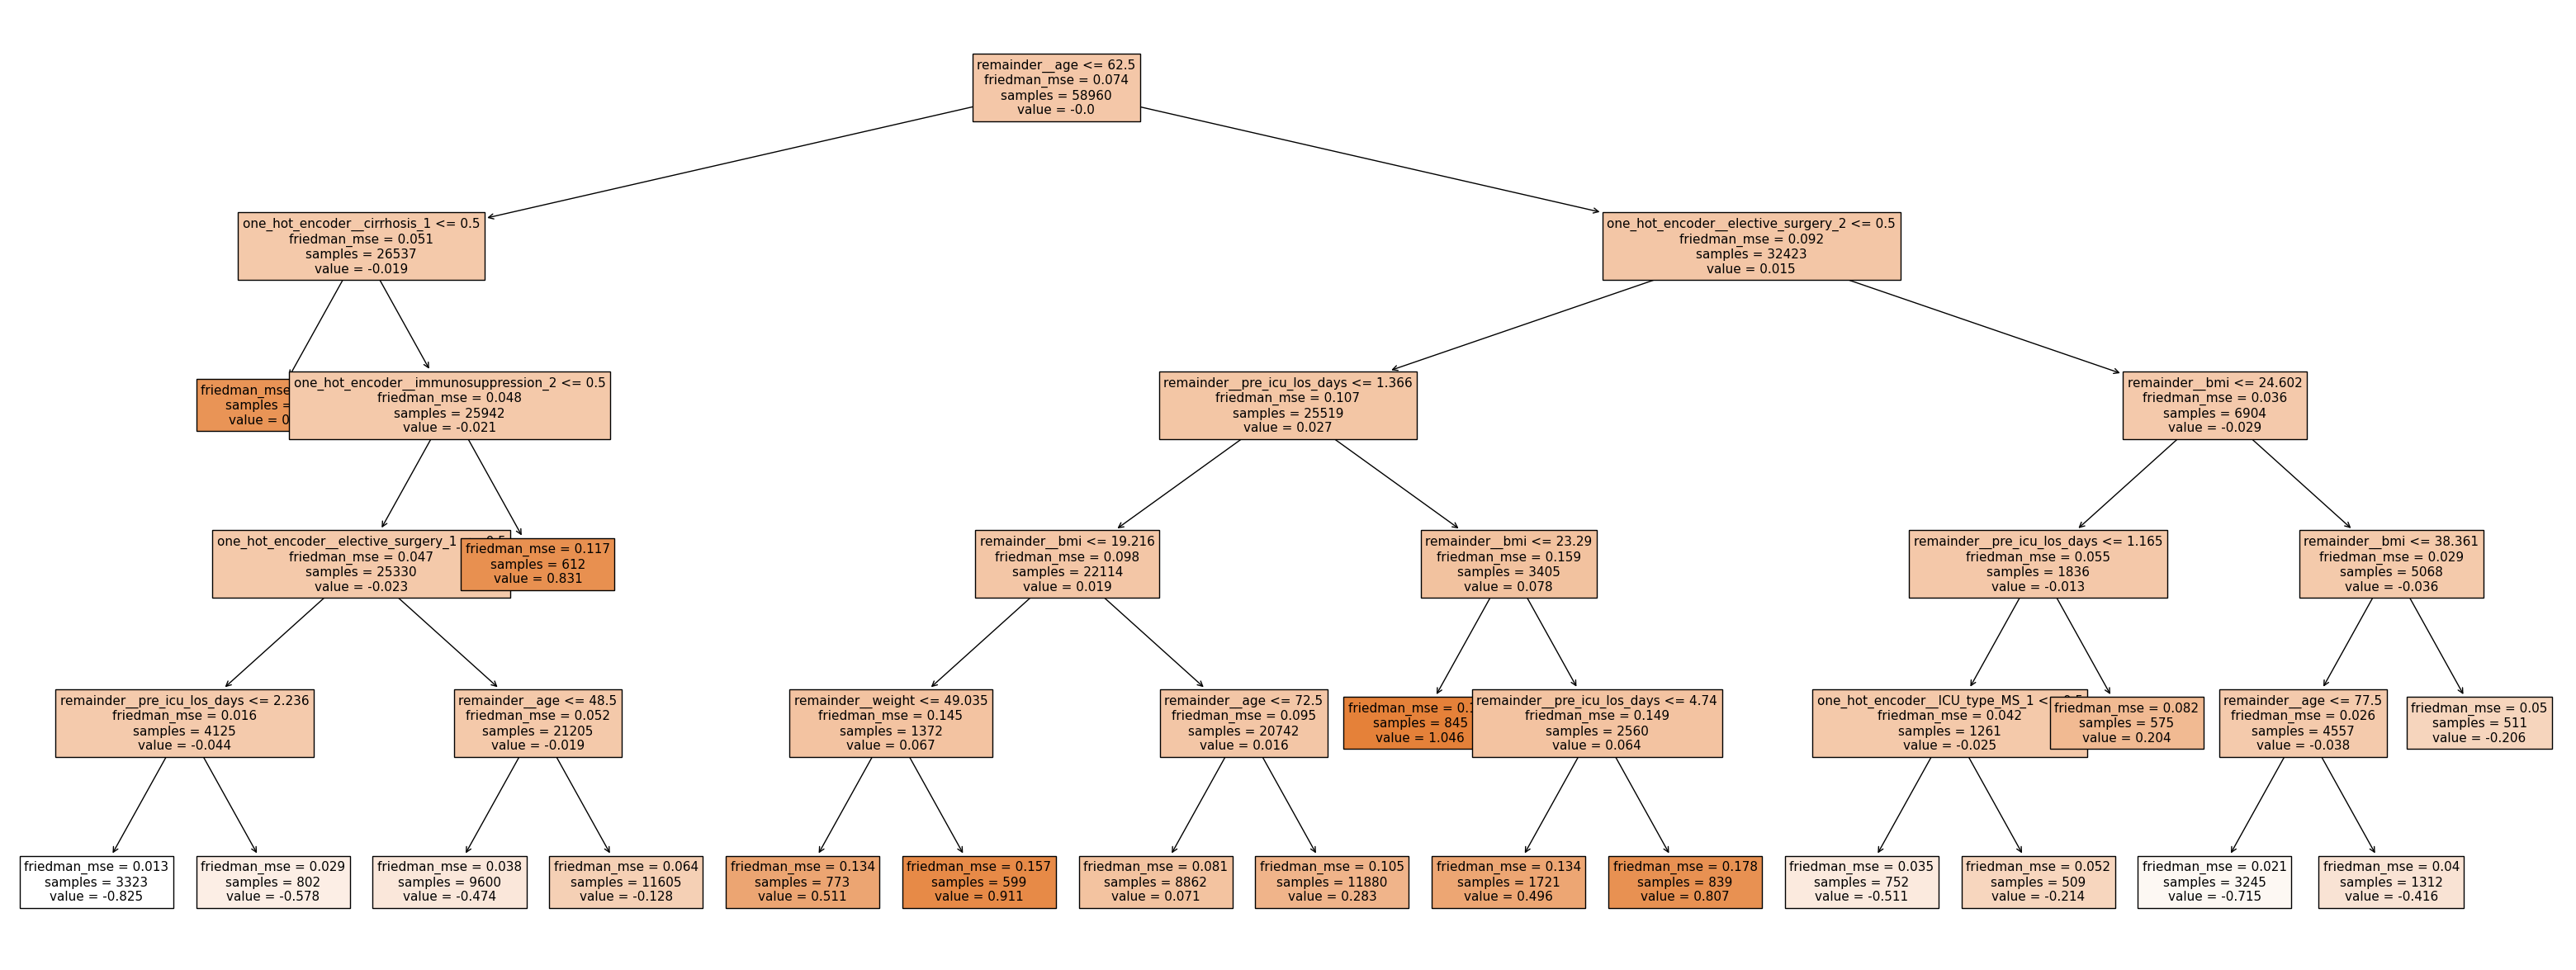

In [22]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

gb_model = model2.named_steps['xg_boost']

#tree_structure = tree_model2.tree_
#n_nodes = tree_structure.node_count
#children_left = tree_structure.children_left
#children_right = tree_structure.children_right
#feature = tree_structure.feature
#threshold = tree_structure.threshold

#for node in range(n_nodes):
#    if children_left[node] != children_right[node]:  # Check if it's a non-leaf node
#        print(f"Node {node}: Split on feature {feature[node]}, threshold {threshold[node]}")
#    else:  # It's a leaf node
#        print(f"Node {node}: Leaf node")

tree_index = 4
tree = gb_model.estimators_[tree_index][0]
        
feature_names = ct.get_feature_names_out()

# Plot the XG_Boost Tree
plt.figure(figsize=(40, 15))
plot_tree(tree, filled=True, feature_names=feature_names, fontsize=11)

plt.savefig("XG_tree_plot4.jpg", format="jpg")


In [23]:
####SHAP to explain 
import shap
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

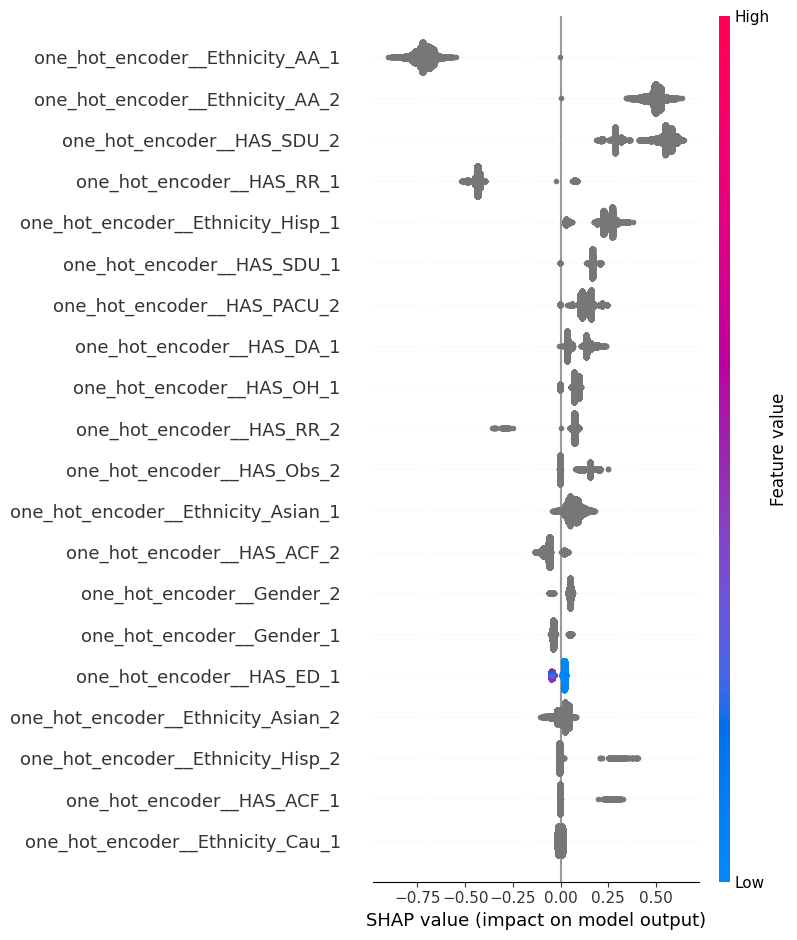

In [34]:
X_train = train.drop('hospital_death', axis=1)

explainer = shap.Explainer(model2.named_steps['xg_boost'], check_additivity=False)
shap_values = explainer.shap_values(X_train,  check_additivity=False)

shap.summary_plot(shap_values, X_train, feature_names=feature_names)

